<a href="https://colab.research.google.com/github/sarenales/OFA-VSR/blob/main/Analisis_OFAVSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OFA

Preparación del modelo.

Se utilizará OFA-base.

In [ ]:
!git clone --single-branch --branch feature/add_transformers https://github.com/OFA-Sys/OFA

Cloning into 'OFA'...
remote: Enumerating objects: 5745, done.
remote: Counting objects: 100% (916/916), done.
remote: Compressing objects: 100% (254/254), done.
remote: Total 5745 (delta 695), reused 662 (delta 662), pack-reused 4829
Receiving objects: 100% (5745/5745), 97.78 MiB | 31.60 MiB/s, done.
Resolving deltas: 100% (2243/2243), done.
Updating files: 100% (3223/3223), done.


In [ ]:
!pip install OFA/transformers/

Processing ./OFA/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 6.3 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.18.0.dev0-py3-none-any.whl size=3916748 sha256=f6258ae8d0070412931093171dc2d57e66a645a6b4720297d33c5d0ed68665e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-rdjfoine/wheels/0b/bc/ea/00b6b8998c20c4fe55affe6062a2cddda80308ef9bd5d5877c
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.2
    Uninstalling transformers-4.40.2:
      Successfully uninstalled transformers-4.40.2


In [ ]:
!git lfs install
!git clone https://huggingface.co/OFA-Sys/OFA-base

Git LFS initialized.
Cloning into 'OFA-base'...
remote: Enumerating objects: 52, done.
remote: Total 52 (delta 0), reused 0 (delta 0), pack-reused 52 (from 1)
Unpacking objects: 100% (52/52), 541.04 KiB | 3.07 MiB/s, done.


In [ ]:
from transformers.models.ofa.generate import sequence_generator

In [ ]:
from transformers import OFATokenizer, OFAModel
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ofa_model = OFAModel.from_pretrained("./OFA-base", use_cache=False).to(device)
ofa_tokenizer = OFATokenizer.from_pretrained("./OFA-base")

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


./OFA-base
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [ ]:
from PIL import Image
from torchvision import transforms
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 256

def load_image(image):
    patch_resize_transform = transforms.Compose([
            transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    patch_img = patch_resize_transform(image).unsqueeze(0).to(device)
    return patch_img

# DATASET

Comenzaremos obteniendo nuestras instancias del conjunto de datos VSR (Visual Scene Representation). A continuación, realizaremos un filtrado y adaptaremos los datos según nuestras necesidades para el proyecto en cuestión.

En el conjunto de datos original de VSR, cada instancia cuenta con diversos atributos, como "imagen", "link_imagen", "caption", etc. Nuestro primer paso será filtrar estas instancias y seleccionar únicamente aquellas que tengan la etiqueta (label) igual a 1. Posteriormente, nos quedaremos solamente con los atributos necesarios para nuestro análisis, descartando aquellos que no son relevantes. Además, añadiremos un par de atributos adicionales, como la relación opuesta a la que se describe en la leyenda original, junto con su respectiva descripción.

Nuestro dataset se guardará en la variable **filtro**.

In [ ]:
!git clone https://github.com/cambridgeltl/visual-spatial-reasoning.git

Cloning into 'visual-spatial-reasoning'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 253 (delta 37), reused 17 (delta 17), pack-reused 204
Receiving objects: 100% (253/253), 10.98 MiB | 18.68 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [ ]:
import json
archivo_jsonl = "/content/visual-spatial-reasoning/data/data_files/all_vsr_validated_data.jsonl"
train = []
with open(archivo_jsonl, "r") as f:
  for linea in f:
    objeto = json.loads(linea)
    train.append(objeto)

In [ ]:
diccionario_opuesto ={
    # Adjacency (10)
    "Adjacent to":"alongside",
    "alongside": "Adjacent to",
    "at the side of":"against",
    "at the right side of":"at the left side of",
    "at the left side of": "at the right side of",
    "attached to":"against",
    "at the back of":"ahead of",
    "ahead of":"at the back of",
    "against": "ahead of",
    "at the edge of":"Adjacent to",

  # Directional (16)
    "off":"up",
    "past":"across from",
    "toward":"down",
    "down":"up",
    "deep down":"up",
    "up":"deep down",
    "away from":"across from",
    "along":"Adjacent to",
    "around":"off",
    "from":"away from",
    "into":"off",
    "to":"in front of",
    "across":"off"  ,
    "across from":"Adjacent to" ,
    "through":"Adjacent to",
    "down from":"into"    ,

  # Orientation (4)
    "facing":"facing away from"  ,
    "facing away from":"facing"  ,
    "parallel to":"perpendicular to"  ,
    "perpendicular to":"parallel to"  ,

  # Projective (12)
    "on top of":"beneath"  ,
    "beneath":"on top of"  ,
    "beside":"far from"  ,
    "behind":"in front of"  ,
    "left of":"right of"  ,
    "right of":"left of"  ,
    "under":"over"  ,
    "in front of":"behind"  ,
    "below":"above"  ,
    "above":"below"  ,
    "over":"under"  ,
    "in the middle of": "above",

    # Proximity (6)
    "by":"far from"  ,
    "close to": "far from" ,
    "near":"far from"  ,
    "far from":"close to"  ,
    "far away from":"close to"  ,

    # Topological (18)
    "Connected to":"detached from"  ,
    "detached from":"part of"  ,
    "has as a part":"detached from"  ,
    "part of":"detached from"  ,
    "contains":"detached from"  ,
    "within":"out of"  ,
    "at":"out of"  ,
    "on":"out of"  ,
    "in":"out of"  ,
    "with":"out of"  ,
    "surrounding":"out of"  ,
    "among":"out of"  ,
    "consists of":"out of"  ,
    "out of":"between"  ,
    "between":"out to"  ,
    "inside":"outside"  ,
    "outside":"inside"  ,
    "touching": "detached from"  ,

    # Unallocated (6)
    "beyond":"enclosed by"  ,
    "next to":"beyond"  ,
    "opposite to":"Adjacent to"  ,
    "after":"among"  ,
    #"among":"after"  ,
    "enclosed by":"beyond"
}

In [ ]:
def obtener_contrario(palabra, diccionario):
  if palabra in diccionario:
    return diccionario[palabra]
  else:
    return "Palabra no encontrada"

In [ ]:
def saber_split(url):
  if 'train' in url:
    return "train"
  else:
    return "dev"

In [ ]:
filtro = {}
cont = 0

for elemento in train:
  if elemento.get("label") == 1:

    nuevo_elemento = {
        "image" : elemento.get("image"),
        "image_link": elemento.get("image_link"),
        "caption+" : elemento.get("caption"),
        "caption-" :  elemento.get("caption").replace(elemento.get("relation"),  obtener_contrario(elemento.get("relation"), diccionario_opuesto)),
        "relation+" : elemento.get("relation"),
        "relation-" : obtener_contrario(elemento.get("relation"), diccionario_opuesto),
        "split": saber_split(elemento.get("image_link"))
    }

    filtro[cont] = nuevo_elemento
    cont +=1

with open("filtrado.json", "w") as archivo:
  json.dump(filtro, archivo)


print(f"Nuevo JSON creado exitosamente con los elementos filtrados. Número de elementos {cont}.")

Nuevo JSON creado exitosamente con los elementos filtrados. Número de elementos 5621.


# Preprocesos

In [ ]:
import json
import torch
import numpy as np
import time
import requests
from io import BytesIO
from torch import nn

In [ ]:
def token_imag(url):
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  patch_img = load_image(image.convert("RGB"))
  return patch_img, image

In [ ]:
def token_cap(caption):
  cap = "Does the image describe the following sentence?  " + caption
  text = ofa_tokenizer([cap], padding=True, truncation=True, return_tensors="pt").to(device).input_ids
  return text

# Extracción de datos (Evaluaciones 1 - 2)

Aquí solamente almacenaremos los datos necesarios probados por el modelo.

Por cada instancia vamos a almacenar las probabilidades de salir la **primera palabra** yes/no con el caption positivo y con el caption negativo. Para ello se comprueba que la primera palabra es yes/no. En caso de que no sea la probabilidad la marcamos como 0.0%. Además, almacenamos también los captions que OFA nos devuelve.

Tiempo de análisis aproximado: **5h 30min**

In [ ]:
def input_model(caption, patch_img):
  gen_output_0 = ofa_model.generate(caption, patch_images=patch_img,num_beams=1, no_repeat_ngram_size=1,  return_dict_in_generate=True , output_scores=True )
  ofa_caption_0 = ofa_tokenizer.batch_decode(gen_output_0[0], skip_special_tokens=True)[0].strip()
  return ofa_caption_0, gen_output_0

In [ ]:
with open("filtrado.json", "r") as f:
    datos = json.load(f)

In [ ]:
def comprobar_primera_p(ofa_caption_0):
    palabras = ofa_caption_0.split()
    yn = ["yes", "no","yes,","no,","yes.","no.","yes..", "no..", "yes!","no!", "yes...","no..."]
    if not palabras:
        return False
    elif palabras[0].lower() in yn:
      return True
    return False

def comprobar_primera_yes(ofa_caption_0):
  palabras = ofa_caption_0.split()
  if not palabras:
    return False
  elif palabras[0].lower() == "yes":
    return True
  return False

In [ ]:
def diferencia_YN(gen_output_0):
  probabilities = nn.functional.softmax(gen_output_0[1][0], dim=-1)
  probYES = probabilities[0][tokens.get("Ġyes")].item()
  probNO = probabilities[0][tokens.get("Ġno")].item()
  return abs(probYES - probNO)

In [ ]:
def get_probabilidades(gen_output_0):
  probabilities = nn.functional.softmax(gen_output_0[1][0], dim=-1)
  probYES = probabilities[0][tokens.get("Ġyes")].item()
  probNO = probabilities[0][tokens.get("Ġno")].item()
  return probYES, probNO

In [ ]:
resultados = {}
tokens = ofa_tokenizer.get_vocab()

cont = 0

for indice, (clave,valor) in enumerate(datos.items()):
  probYESP = 0.0
  probNOP = 0.0
  probYESN = 0.0
  probNON = 0.0
  respP = ""
  respN = ""

  url = valor["image_link"]
  patch_img = token_imag(url)[0]

  caption = token_cap(valor["caption+"])
  ofa_caption_0, gen_output_0 = input_model(caption, patch_img)
  respP = ofa_caption_0

  if comprobar_primera_p(ofa_caption_0):
    probYESP, probNOP = get_probabilidades(gen_output_0)

    caption = token_cap(valor["caption-"])
    ofa_caption_0, gen_output_0 = input_model(caption, patch_img)
    respN = ofa_caption_0
    if comprobar_primera_p(ofa_caption_0):
      probYESN, probNON = get_probabilidades(gen_output_0)

  valor["PY+"] = probYESP
  valor["PN+"] = probNOP
  valor["response+"] = respP
  valor["PY-"] = probYESN
  valor["PN-"] = probNON
  valor["response-"] = respN
  resultados[cont] = valor
  cont += 1

with open("resultados1.json", "w") as archivo:
  json.dump(resultados, archivo)

# **Evaluación 1**: ITM (Yes/No)

Vamos a evaluar nuestro conjunto de datos en el framework de aprendizaje automático OFA (One-for-All). Para cada imagen que disponemos, introduciremos tanto la imagen real como su descripción correspondiente, que incluye una relación espacial que describe adecuadamente la imagen. Luego, repetiremos este proceso, pero esta vez introduciremos una descripción que no corresponde realmente a la imagen. De esta manera, en el primer caso esperamos que el modelo nos devuelva un resultado positivo (YES), mientras que en el segundo caso esperamos un resultado negativo (NO).

En esta primera fase de evaluación, nos enfocaremos únicamente en el resultado de la predicción y realizaremos un análisis de los resultados obtenidos.

Durante el análisis, registraremos el número de Verdaderos Positivos (TP), Falsos Negativos (FN), Verdaderos Negativos (TN) y Falsos Positivos (FP), con el fin de construir posteriormente una matriz de confusión.

Luego, procederemos a graficar el porcentaje de las relaciones que han sido clasificadas como TP, FN, etc., con el objetivo de identificar patrones y tendencias en el rendimiento del modelo. Además de ver cuáles son las relaciones que más difícil son de identificar para el moder.

## Analisis ITM

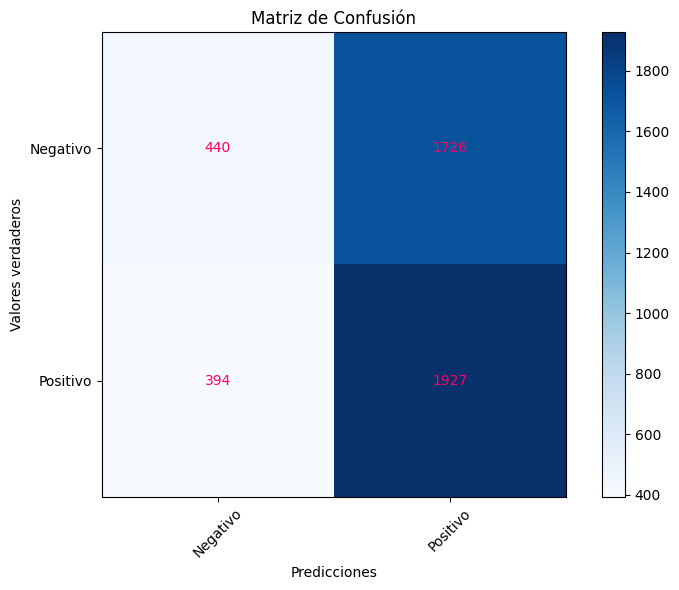

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

matriz_confusion = np.array([[TN, FP], [FN, TP]])
etiquetas = ['Negativo', 'Positivo']


plt.figure(figsize=(8, 6))
plt.imshow(matriz_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()


ticks = np.arange(len(etiquetas))
plt.xticks(ticks, etiquetas, rotation=45)
plt.yticks(ticks, etiquetas)


for i in range(len(etiquetas)):
    for j in range(len(etiquetas)):
        plt.text(j, i, matriz_confusion[i, j], ha='center', va='center', color='#ff0066')

plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.tight_layout()
plt.show()

In [ ]:
print(TP)
print(FN)
print(TN)
print(FP)
print(R)

1927
394
440
1726
1081


In [ ]:
dic_TP_sorted = sorted(dic_TP.items(), key=lambda x: x[1], reverse=True)
dic_FN_sorted = sorted(dic_FN.items(), key=lambda x: x[1], reverse=True)
dic_TN_sorted = sorted(dic_TN.items(), key=lambda x: x[1], reverse=True)
dic_FP_sorted = sorted(dic_FP.items(), key=lambda x: x[1], reverse=True)
dic_R_sorted = sorted(dic_R.items(), key=lambda x: x[1], reverse=True)

<ipython-input-27-ffba67296fc1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=relaciones, y=apariciones, palette="viridis")


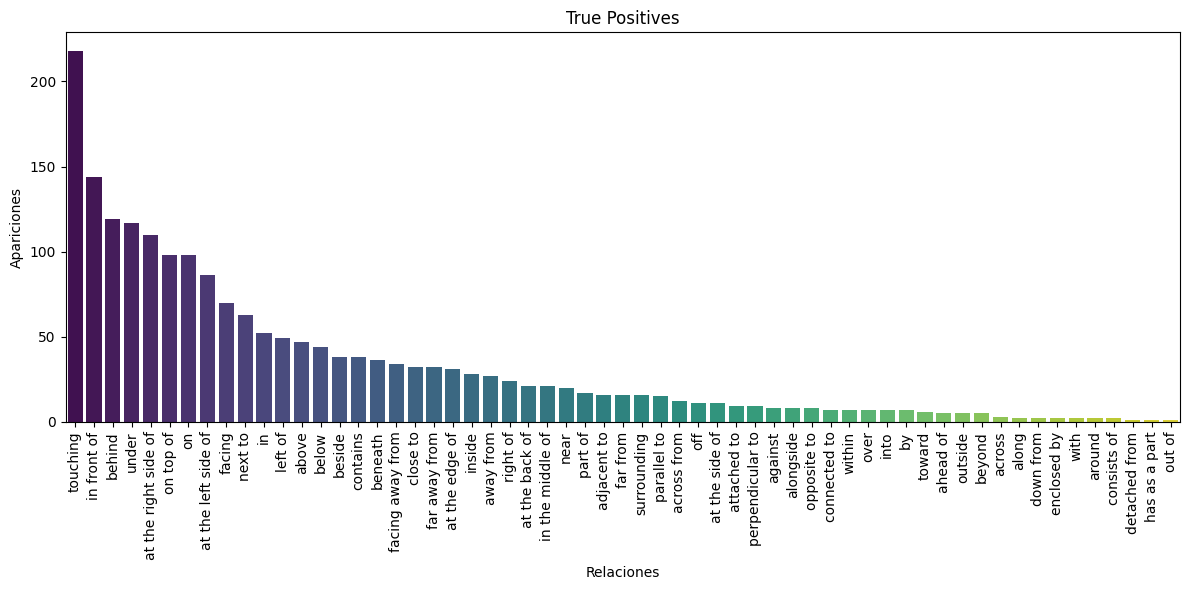

In [ ]:
import seaborn as sns

relaciones, apariciones = zip(*dic_TP_sorted)
plt.figure(figsize=(12, 6))
sns.barplot(x=relaciones, y=apariciones, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Relaciones")
plt.ylabel("Apariciones")
plt.title("True Positives")
plt.tight_layout()
plt.show()

<ipython-input-28-8429ffeb62a3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=relaciones, y=apariciones, palette="viridis")


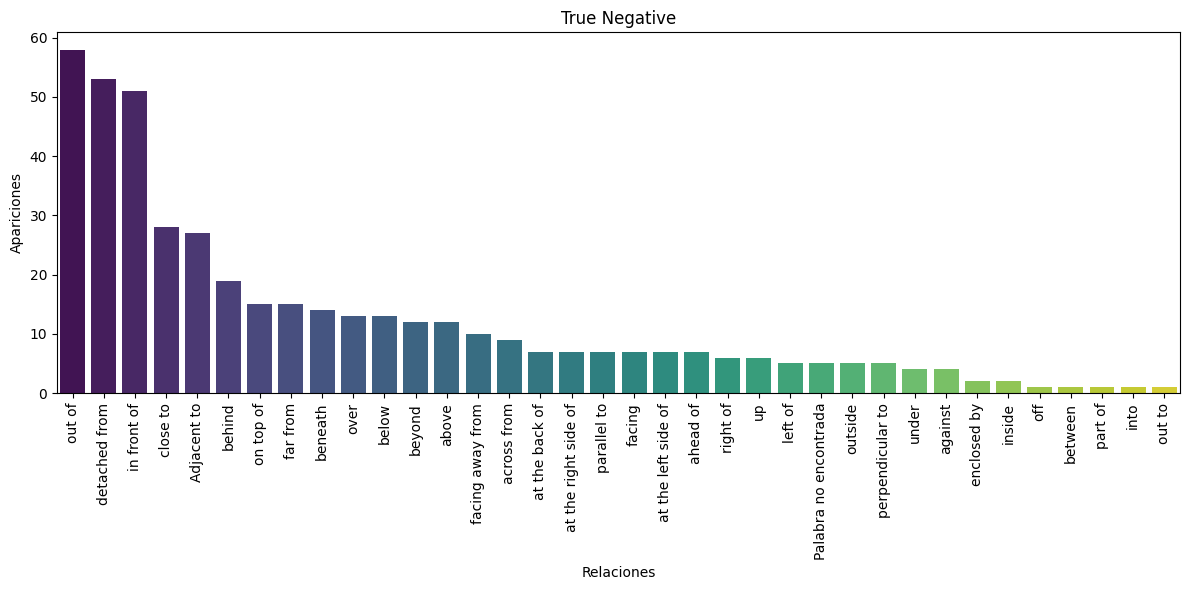

In [ ]:
relaciones, apariciones = zip(*dic_TN_sorted)
plt.figure(figsize=(12, 6))
sns.barplot(x=relaciones, y=apariciones, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Relaciones")
plt.ylabel("Apariciones")
plt.title("True Negative")
plt.tight_layout()
plt.show()

<ipython-input-29-8f535c3bcf7f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=relaciones, y=apariciones, palette="viridis")


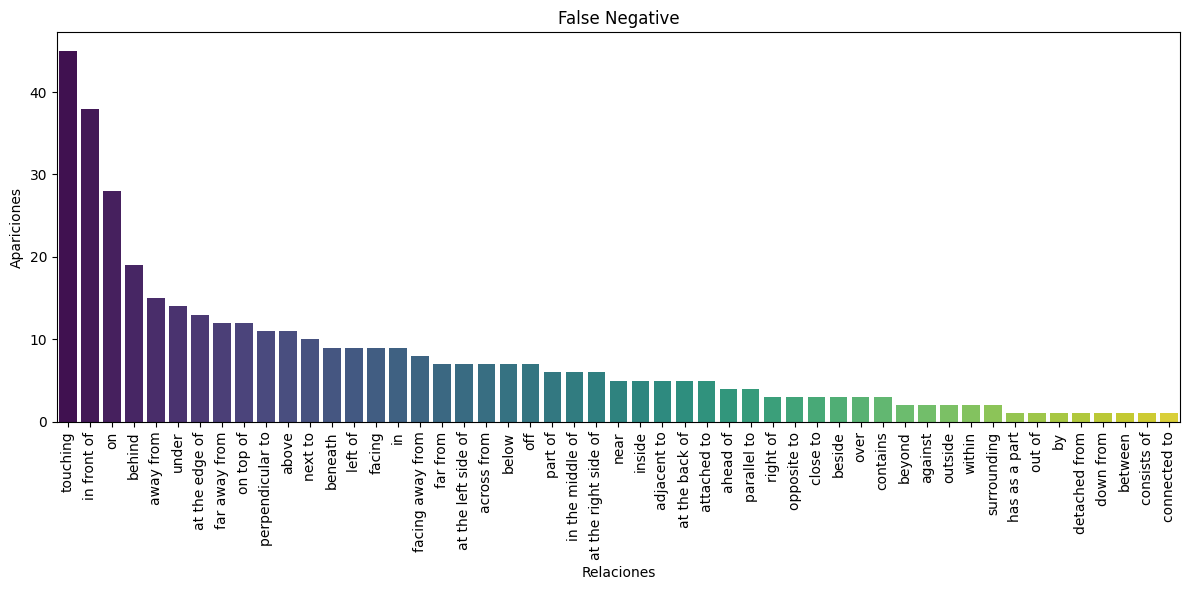

In [ ]:
relaciones, apariciones = zip(*dic_FN_sorted)
plt.figure(figsize=(12, 6))
sns.barplot(x=relaciones, y=apariciones, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Relaciones")
plt.ylabel("Apariciones")
plt.title("False Negative")
plt.tight_layout()
plt.show()

<ipython-input-30-93e79e7d559b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=relaciones, y=apariciones, palette="viridis")


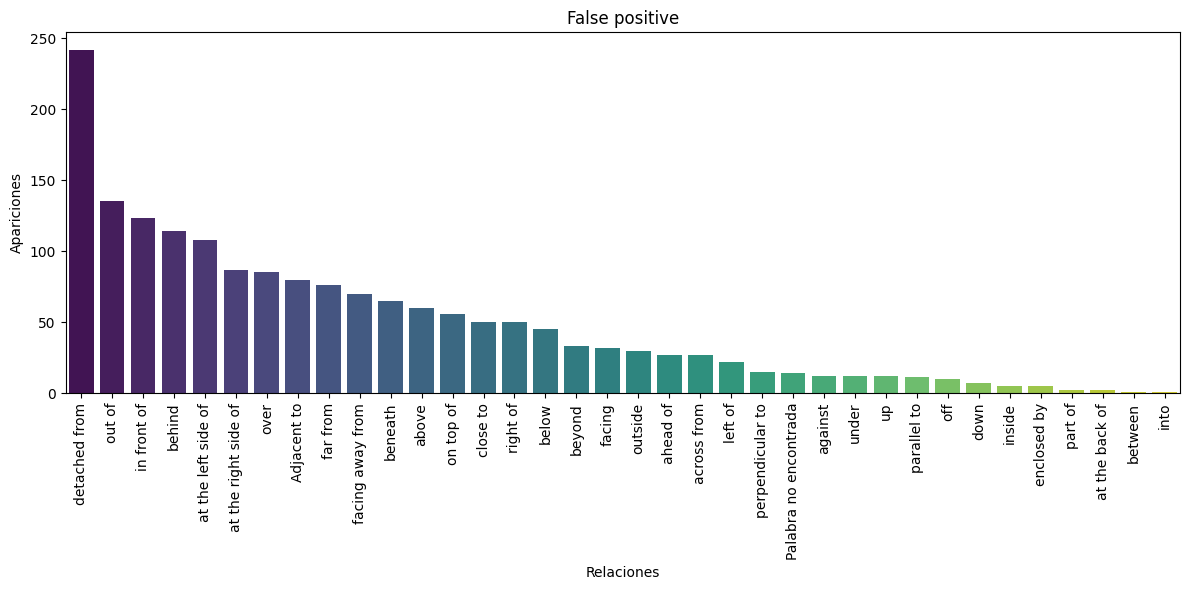

In [ ]:
relaciones, apariciones = zip(*dic_FP_sorted)
plt.figure(figsize=(12, 6))
sns.barplot(x=relaciones, y=apariciones, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Relaciones")
plt.ylabel("Apariciones")
plt.title("False positive")
plt.tight_layout()
plt.show()

<ipython-input-31-8882c03c43b9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=relaciones, y=apariciones, palette="viridis")


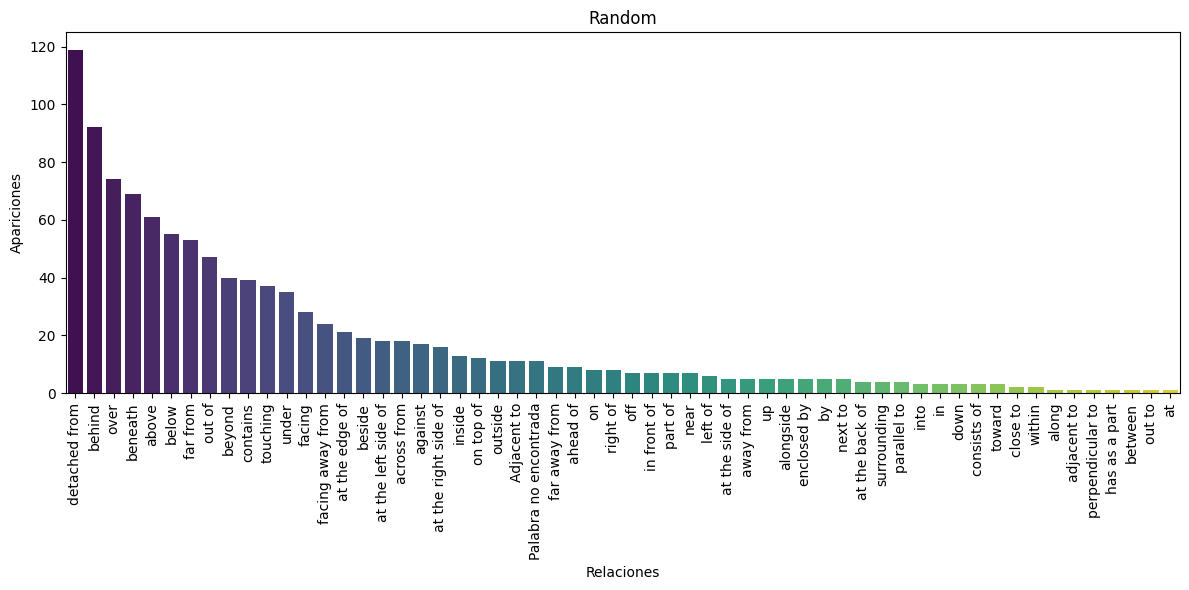

In [ ]:
relaciones, apariciones = zip(*dic_R_sorted)
plt.figure(figsize=(12, 6))
sns.barplot(x=relaciones, y=apariciones, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Relaciones")
plt.ylabel("Apariciones")
plt.title("Random")
plt.tight_layout()
plt.show()

# **Evaluación 2**: Probabilidades (Logits)

El objetivo aquí es contrastar con los dos inputs diferentes por cada imagen, caption positivo y caption negativo, ver si el modelo es capaz de elegir el caption correcto (el positivo).

Para ello nos fijaremos en los logits (probabilidades) que saca el modelo. Constrastaremos la probabilidad del caption positivo y negativo.


## Análisis 1: Probabilidades

In [2]:
import json

with open("resultados1.json", "r") as resultados_json:
    datos = json.load(resultados_json)

In [3]:
def acierta_1(PYP,PNP,PYN,PNN):
  DP = abs(PYP - PNP)
  DN = abs(PYN - PNN)

  if DN == 0.0:
    return 0
  if DP == 0.0:
    return 0

  if DP > DN :
    return 1
  return 0

In [5]:
datos_filtrados = []

for indice, (clave,valor) in enumerate(datos.items()):
  rel_esp = valor["relation+"]
  acierto = acierta_1(valor["PY+"],valor["PN+"],valor["PY-"],valor["PN-"])
  datos_filtrados.append({"relacion_espacial": rel_esp, "acierto": acierto})

In [50]:
predicciones_correctas = sum(1 for instancia in datos_filtrados if instancia["acierto"] == 1)

total_predicciones = len(datos_filtrados)

accuracy = predicciones_correctas / total_predicciones

print("Número de predicciones correctas:  ", predicciones_correctas)
print("Total de predicciones:             ", total_predicciones)
print("------------------------------------------------------")
print("Accuracy:                          ", accuracy)

Número de predicciones correctas:   3042
Total de predicciones:              5621
------------------------------------------------------
Accuracy:                           0.5411848425547056


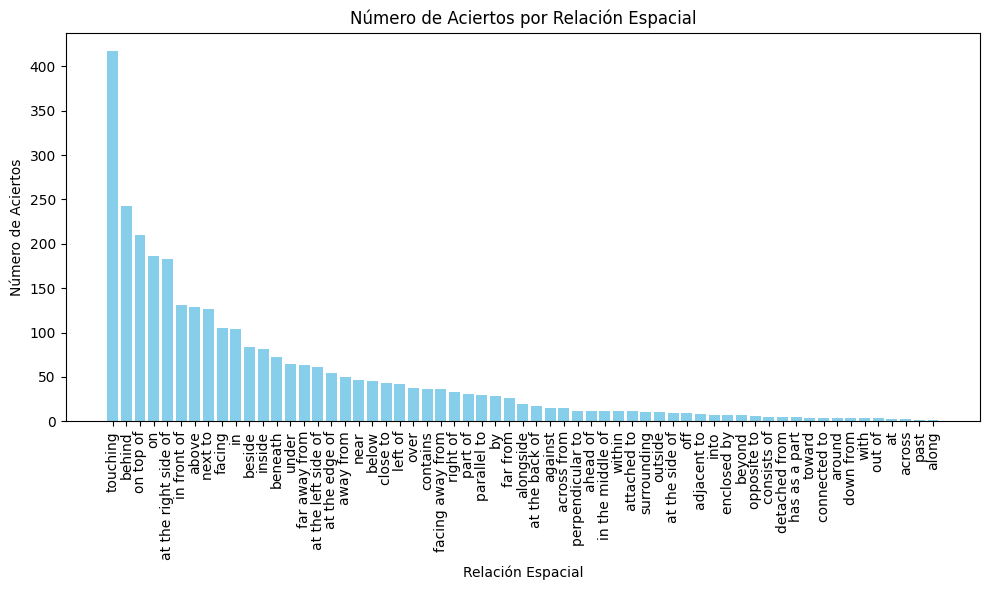

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame(datos_filtrados)
aciertos_por_relacion = df[df['acierto'] == 1].groupby('relacion_espacial').size()
aciertos_por_relacion = aciertos_por_relacion.reset_index(name='numero_aciertos')
aciertos_por_relacion = aciertos_por_relacion.sort_values(by='numero_aciertos', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(aciertos_por_relacion['relacion_espacial'], aciertos_por_relacion['numero_aciertos'], color='skyblue')
plt.xlabel('Relación Espacial')
plt.ylabel('Número de Aciertos')
plt.title('Número de Aciertos por Relación Espacial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


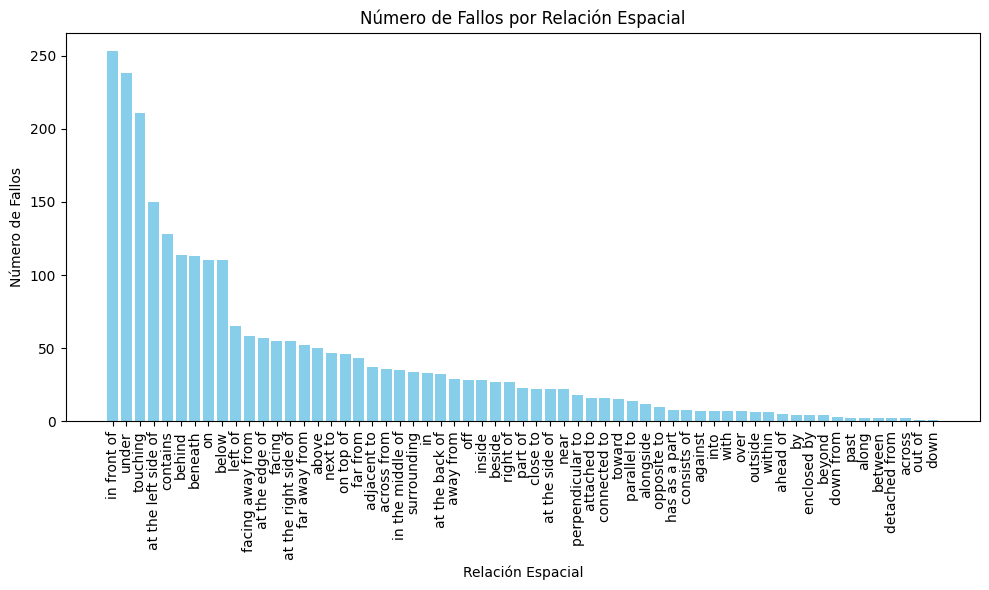

In [11]:
df = pd.DataFrame(datos_filtrados)

fallos_por_relacion = df[df['acierto'] == 0].groupby('relacion_espacial').size()
fallos_por_relacion = fallos_por_relacion.reset_index(name='numero_fallos')
fallos_por_relacion = fallos_por_relacion.sort_values(by='numero_fallos', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(fallos_por_relacion['relacion_espacial'], fallos_por_relacion['numero_fallos'], color='skyblue')
plt.xlabel('Relación Espacial')
plt.ylabel('Número de Fallos')
plt.title('Número de Fallos por Relación Espacial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [23]:
categories = {
    "Adjacency": [
        "adjacent to", "alongside", "at the side of", "at the right side of",
        "at the left side of", "attached to", "at the back of", "ahead of",
        "against", "at the edge of"
    ],
    "Directional": [
        "off", "past", "toward", "down", "deep down", "up", "away from",
        "along", "around", "from", "into", "to", "across", "across from",
        "through", "down from"
    ],
    "Orientation": [
        "facing", "facing away from", "parallel to", "perpendicular to"
    ],
    "Projective": [
        "on top of", "beneath", "beside", "behind", "left of", "right of",
        "under", "in front of", "below", "above", "over", "in the middle of"
    ],
    "Proximity": [
        "by", "close to", "near", "far from", "far away from"
    ],
    "Topological": [
        "connected to", "detached from", "has as a part", "part of", "contains",
        "within", "at", "on", "in", "with", "surrounding", "among",
        "consists of", "out of", "between", "inside", "outside", "touching"
    ],
    "Unallocated": [
        "beyond", "next to", "opposite to", "after", "among", "enclosed by"
    ]
}

In [26]:
def categorize_relation(relation):
    for category, relations in categories.items():
        if relation in relations:
            return category
    return "Unknown"

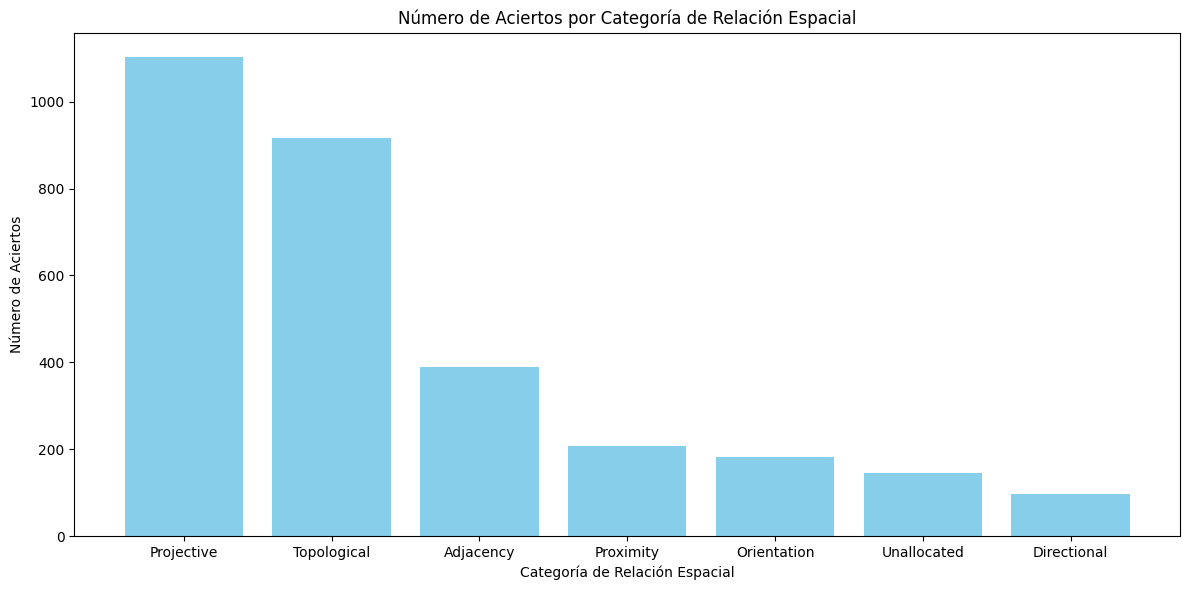

In [27]:
df = pd.DataFrame(datos_filtrados)

df['categoria'] = df['relacion_espacial'].apply(categorize_relation)

aciertos_por_categoria = df[df['acierto'] == 1].groupby('categoria').size()
aciertos_por_categoria = aciertos_por_categoria.reset_index(name='numero_aciertos')
aciertos_por_categoria = aciertos_por_categoria.sort_values(by='numero_aciertos', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(aciertos_por_categoria['categoria'], aciertos_por_categoria['numero_aciertos'], color='skyblue')
plt.xlabel('Categoría de Relación Espacial')
plt.ylabel('Número de Aciertos')
plt.title('Número de Aciertos por Categoría de Relación Espacial')


plt.tight_layout()
plt.show()

## Análisis 2: Criterio probabilidades normalizadas

In [51]:
def acierta_2(PYP,PNP,PYN,PNN):
  if PYP == 0.0:
    return 0
  if PYN == 0.0:
    return 0

  total_prob_p = PYP + PNP
  normalized_prob_yes_p = PYP / total_prob_p
  normalized_prob_no_p = PNP / total_prob_p

  total_prob_n = PYN + PNN
  normalized_prob_yes_n = PYN / total_prob_n
  normalized_prob_no_n = PNN / total_prob_n

  if normalized_prob_yes_p > normalized_prob_no_n:
    return 1
  return 0


In [52]:
datos_filtrados = []

for indice, (clave,valor) in enumerate(datos.items()):
  rel_esp = valor["relation+"]
  acierto = acierta_2(valor["PY+"],valor["PN+"],valor["PY-"],valor["PN-"])
  datos_filtrados.append({"relacion_espacial": rel_esp, "acierto": acierto})

In [54]:
predicciones_correctas = sum(1 for instancia in datos_filtrados if instancia["acierto"] == 1)

total_predicciones = len(datos_filtrados)

accuracy = predicciones_correctas / total_predicciones

print("Número de predicciones correctas:  ", predicciones_correctas)
print("Total de predicciones:             ", total_predicciones)
print("------------------------------------------------------")
print("Accuracy:                          ", accuracy)

Número de predicciones correctas:   4780
Total de predicciones:              5621
------------------------------------------------------
Accuracy:                           0.8503824942181106


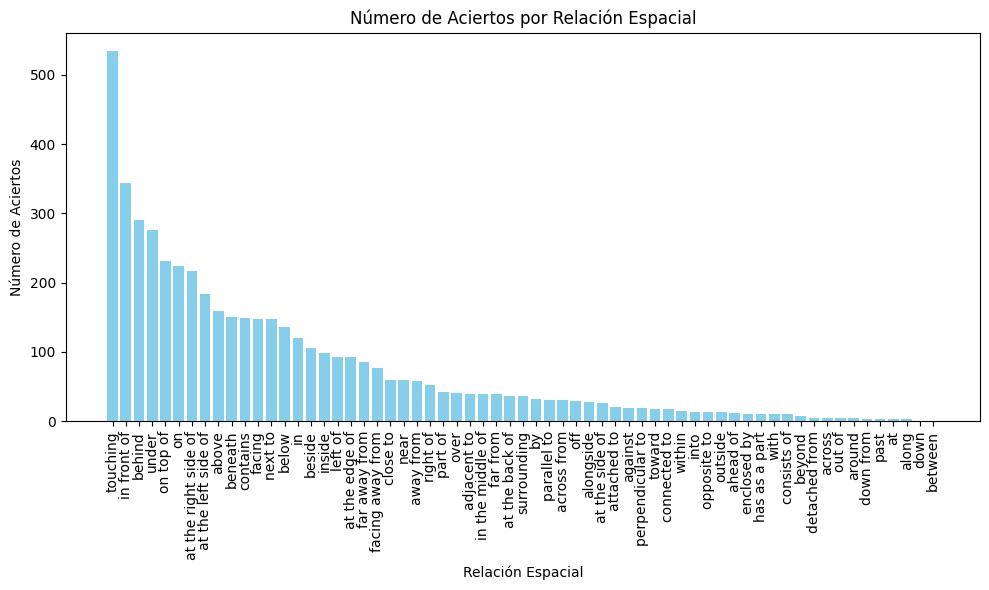

In [55]:
df = pd.DataFrame(datos_filtrados)
aciertos_por_relacion = df[df['acierto'] == 1].groupby('relacion_espacial').size()
aciertos_por_relacion = aciertos_por_relacion.reset_index(name='numero_aciertos')
aciertos_por_relacion = aciertos_por_relacion.sort_values(by='numero_aciertos', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(aciertos_por_relacion['relacion_espacial'], aciertos_por_relacion['numero_aciertos'], color='skyblue')
plt.xlabel('Relación Espacial')
plt.ylabel('Número de Aciertos')
plt.title('Número de Aciertos por Relación Espacial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


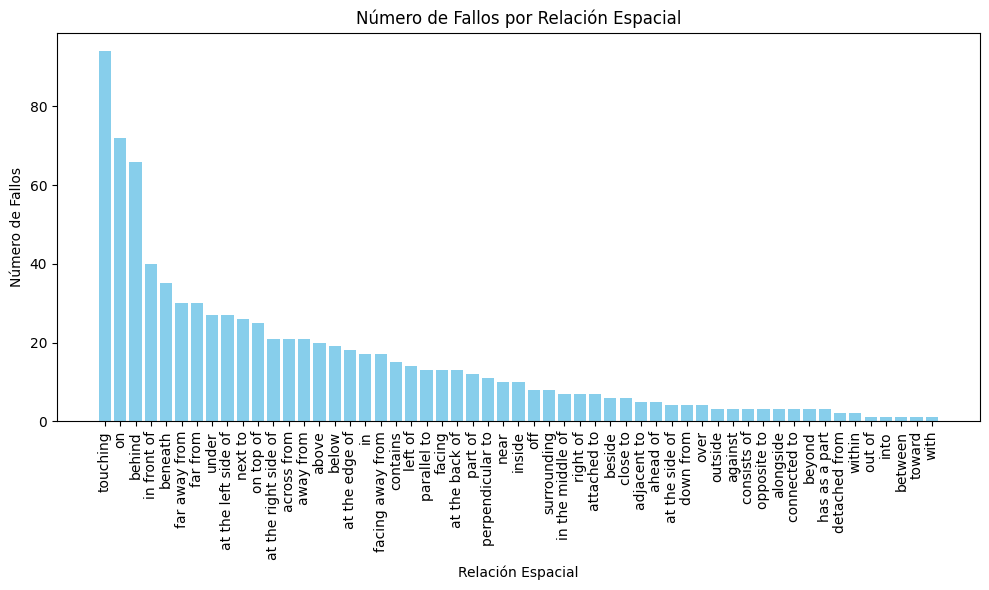

In [56]:
df = pd.DataFrame(datos_filtrados)

fallos_por_relacion = df[df['acierto'] == 0].groupby('relacion_espacial').size()
fallos_por_relacion = fallos_por_relacion.reset_index(name='numero_fallos')
fallos_por_relacion = fallos_por_relacion.sort_values(by='numero_fallos', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(fallos_por_relacion['relacion_espacial'], fallos_por_relacion['numero_fallos'], color='skyblue')
plt.xlabel('Relación Espacial')
plt.ylabel('Número de Fallos')
plt.title('Número de Fallos por Relación Espacial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

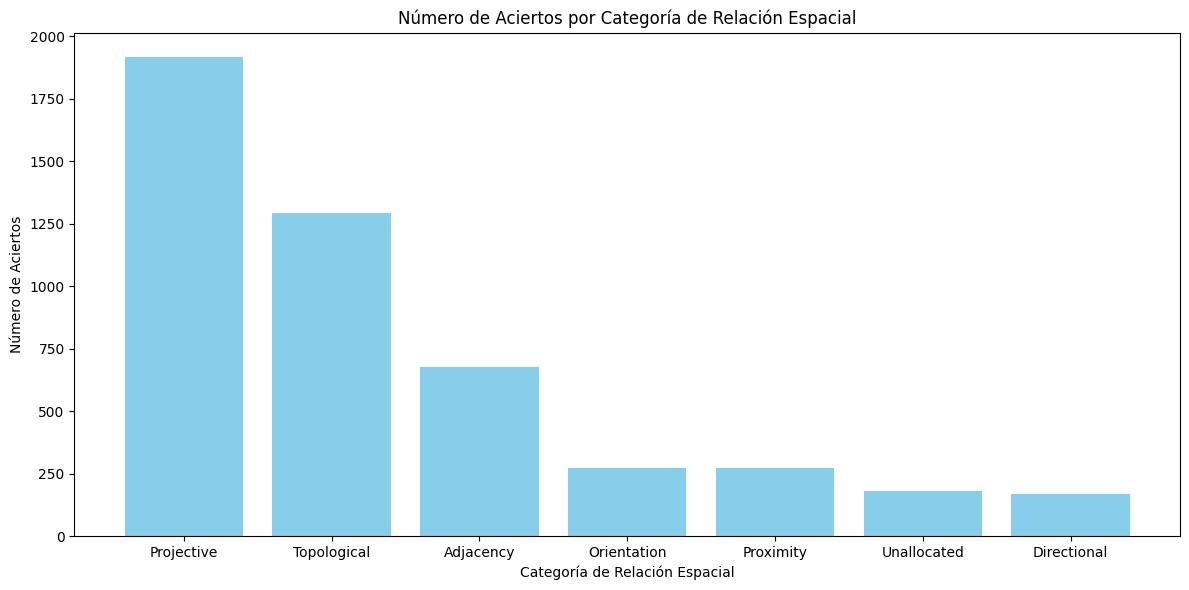

In [57]:
df = pd.DataFrame(datos_filtrados)

df['categoria'] = df['relacion_espacial'].apply(categorize_relation)

aciertos_por_categoria = df[df['acierto'] == 1].groupby('categoria').size()
aciertos_por_categoria = aciertos_por_categoria.reset_index(name='numero_aciertos')
aciertos_por_categoria = aciertos_por_categoria.sort_values(by='numero_aciertos', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(aciertos_por_categoria['categoria'], aciertos_por_categoria['numero_aciertos'], color='skyblue')
plt.xlabel('Categoría de Relación Espacial')
plt.ylabel('Número de Aciertos')
plt.title('Número de Aciertos por Categoría de Relación Espacial')


plt.tight_layout()
plt.show()

## Más análisis de los datos extraídos - Matriz confusión

In [29]:
TP = 0
FN = 0
TN = 0
FP = 0
R = 0

In [30]:
def analisis_TP_FN(probYES, probNO):
  global TP
  global FN
  global R
  if probYES > probNO:
    TP += 1
  elif probYES < probNO:
    FN += 1
  else:
    R += 1

def analisis_TN_FP(probYES, probNO):
  global FP
  global TN
  global R
  if probNO > probYES:
    TN += 1
  elif probNO < probYES:
    FP += 1
  else:
    R += 1

In [31]:
for indice, (clave,valor) in enumerate(datos.items()):
  analisis_TP_FN(valor["PY+"], valor["PN+"])

  analisis_TN_FP(valor["PY-"], valor["PN-"])

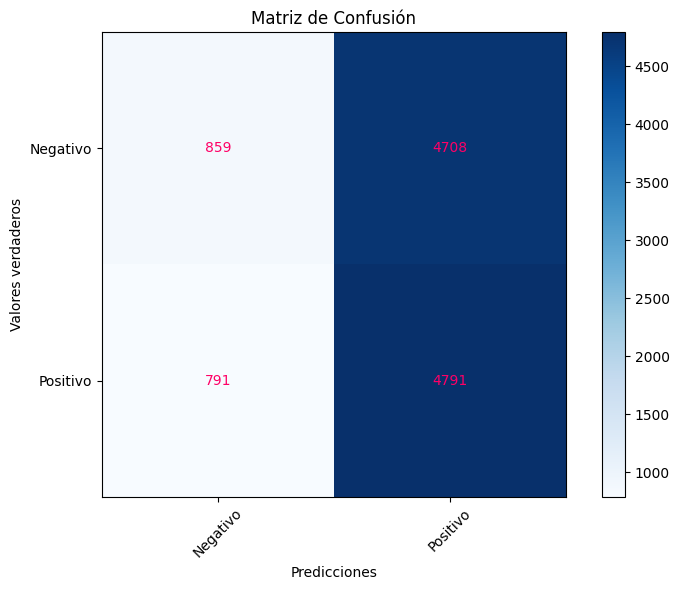

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix

matriz_confusion = np.array([[TN, FP], [FN, TP]])
etiquetas = ['Negativo', 'Positivo']


plt.figure(figsize=(8, 6))
plt.imshow(matriz_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()


ticks = np.arange(len(etiquetas))
plt.xticks(ticks, etiquetas, rotation=45)
plt.yticks(ticks, etiquetas)


for i in range(len(etiquetas)):
    for j in range(len(etiquetas)):
        plt.text(j, i, matriz_confusion[i, j], ha='center', va='center', color='#ff0066')

plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.tight_layout()
plt.show()